In [1]:
import numpy  as np
import json
import matplotlib.pylab as plt
import copy
import cv2
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from tqdm import tqdm
import torch
from collections import OrderedDict
from pathlib import Path
import random

In [34]:
damage = 'origin_crack'
path = Path('/mmdetection/data/merimen_coco/06_04_2022/'+damage)
data = json.load(open(path/'annotations'/'clean_crack_v2.json'))
#print(len(data['images']),len(data['annotations']))

#img_ids = [i['id'] for i in data['images']]
#img_ids_in_annos = set([a['image_id'] for a in data['annotations']])
#print(len(img_ids),len(img_ids_in_annos))
#data['images'] = [i for i in data['images'] if i['id'] in img_ids_in_annos]
print(len(data['images']),len(data['annotations']))


#with open(path/'annotations'/'clean_v2.json', 'w', encoding='utf-8') as f:
#    json.dump(data, f, ensure_ascii=False, indent=4)
tiny_ids_data = json.load(open(path/'annotations'/'tiny_ann_ids.json'))


88512 136964


In [35]:
tiny_ids = []
tiny_ids.extend(tiny_ids_data['tiny_broken_ann_ids'])
tiny_ids.extend(tiny_ids_data['tiny_crack_ann_ids'])
tiny_ids.extend(tiny_ids_data['tiny_hole_ann_ids'])
print(len(tiny_ids))

21460


In [32]:
if damage == 'dent':
    #config_file = '../configs/detectors/dent_detector_latest_segm.py'
    #checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'
    config_file = '../models/cbnet/dent_pseudo/dent_pseudo.py'
    checkpoint_file = '../models/cbnet/dent_pseudo/epoch_30.pth'

if damage == 'loose':
    config_file = '../models/loose/loose.py'
    checkpoint_file = '../models/loose/epoch_9.pth'

if damage == 'origin_crack':
    config_file = '../checkpoints/origin_crack_phase_1/origin_crack.py'
    checkpoint_file = '../checkpoints/origin_crack_phase_1/origin_crack_pahse_1.pth'

if damage == 'scratch':
    config_file = '../checkpoints/scratch_phase_1/scratch_merimen.py'
    checkpoint_file = '../checkpoints/scratch_phase_1/epoch_28.pth'
    #config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
    #checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'
if damage == 'combine_missing':
    config_file = '../work_dirs/missing/missing.py'
    checkpoint_file = '../work_dirs/missing/epoch_10.pth'

In [33]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [36]:
def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    #print(box1,box2)
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

In [16]:
pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []

#image_id = 0
annotation_id = 0
num_tp = 0
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'u_images'/img['file_name']))
    #print(image.shape)
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    
    #print(pred_scores)
    #annos = [[(int(a['bbox'][0]),int(a['bbox'][1])),(int(a['bbox'][0]+a['bbox'][2]),int(a['bbox'][1]+a['bbox'][3]))] 
    #         for a in data['annotations'] if a['image_id']==img['id']]
    
    #print(pred_segms,pred_boxes)
    if pred_segms is None :
        continue
        
    pseudo_segms = pred_segms
    '''
    pseudo_segms = []
    check_ol = [True for i in annos]
    
    for i,box in enumerate(pred_boxes):
        ious = [cal_iou(image,box,a) for a,check in zip(annos,check_ol) if check]
        
        if len(ious) == 0 :
            break
            
        idx = np.argmax(ious)
        
        if ious[idx] >= 0.15:
            #print(box)
            pseudo_segms.append(pred_segms[i])
            check_ol[idx] = False
    '''
    num_tp += len(pseudo_segms)
    if len(pseudo_segms) == 0:
        continue
        
    pseudo_data['images'].append(img)
    
    for segm in pseudo_segms:
        semg = np.array(segm).astype(np.uint8)
        contours, hierarchy = cv2.findContours(semg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            annotation = OrderedDict()
            annotation['id'] = annotation_id
            annotation_id += 1
            annotation['image_id'] = img['id']
            annotation['category_id'] = 0
            annotation['area'] = cv2.contourArea(c)
            c = np.array(c).reshape(-1,2)
            xmax = max(c[:,0])
            xmin = min(c[:,0])
            
            ymax = max(c[:,1])
            ymin = min(c[:,1])
            
            w = xmax - xmin
            h = ymax - ymin
            
            annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
            annotation['segmentation'] = c.reshape(1,-1).tolist()
            
            pseudo_data['annotations'].append(annotation)
print('num tp : ',num_tp)
    
with open(path/'annotations'/'post_pseudo_unlabel_total.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

  0%|                                                                                                                                                                      | 0/49673 [00:00<?, ?it/s]/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49673/49673 [1:26:12<00:00,  9.60it/s]


num tp :  209005


In [72]:
pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []

#image_id = 0
annotation_id = max([a['id'] for a in data['annotations']]) + 1
num_tp = 0
annotations = []

for idx_img,img in enumerate(tqdm(data['images'])):
    #if idx_img < 69422 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    #print(image.shape)
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    
    check_ol = [True for b in pred_boxes]
    for a in data['annotations']:
        if a['image_id'] != img['id']:
            continue
        
        anno_box = [(int(a['bbox'][0]),int(a['bbox'][1])),(int(a['bbox'][0]+a['bbox'][2]),int(a['bbox'][1]+a['bbox'][3]))]
        
        ious = [cal_iou(image,anno_box,pred_box) for pred_box,check in zip(pred_boxes,check_ol) if check]
        
        if len(ious) == 0 :
            if a['id'] in tiny_ids:
                annotations.append(a)
            continue
            
        idx = np.argmax(ious)
        
        if ious[idx] > 0.15:
            check_ol[idx] = False
            pseudo_segm = pred_segms[idx]
            #print(pseudo_segm.sum())
            
            if pseudo_segm.sum() == 0:
                continue
            
            contours, hierarchy = cv2.findContours(np.array(pseudo_segm).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours,key=cv2.contourArea)
            a['segmentation'] = contour.reshape(1,-1).tolist()
            annotations.append(a)
            
#             contour_max_id = np.argmax([cv2.contourArea(c) for c in contours])
            
#             for id_c,c in enumerate(contours):
#                 annotation = OrderedDict()
                
#                 if id_c == contour_max_id:
#                     annotation['id'] = a['id']
#                 else: 
#                     continue
# #                     annotation['id'] = annotation_id
# #                     annotation_id += 1
                    
#                 annotation['image_id'] = img['id']
#                 annotation['category_id'] = a['category_id']
#                 annotation['area'] = cv2.contourArea(c)
#                 c = np.array(c).reshape(-1,2)
#                 xmax = max(c[:,0])
#                 xmin = min(c[:,0])

#                 ymax = max(c[:,1])
#                 ymin = min(c[:,1])

#                 w = xmax - xmin
#                 h = ymax - ymin

#                 annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
#                 annotation['segmentation'] = c.reshape(1,-1).tolist()
                
#                 annotations.append(annotation)
        elif a['id'] in tiny_ids:
            annotations.append(a)

img_ids = list(set([a['image_id'] for a in annotations]))
images = [i for i in data['images'] if i['id'] in img_ids]

pseudo_data['images'] = images
pseudo_data['annotations'] = annotations
    
with open(path/'annotations'/'pseudo_clean_crack_v2.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88512/88512 [3:16:57<00:00,  7.49it/s]


In [27]:
print('racall rate : ',num_tp/len(data['annotations']))

racall rate :  0.9454126783456746


In [77]:
#pseudo_data = json.load(open(path/'annotations'/'post_pseudo_clean_v1.json'))
print(len(pseudo_data['images']),len(pseudo_data['annotations']))

55207 71719


In [46]:
def sample(js_data):
    clr = {
        0:(255,0,0),
        1:(0,255,0)
    }
    #i = random.choice(js_data['images'])
    num = 3
    imgs = random.sample(js_data['images'],num**2)
    #print(i['id'],i['url'])
    #num = 2 
    fig, axis = plt.subplots(num, num,figsize=(15,15))
    
    for idx,i in enumerate(imgs):
        annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) 
                 for a in js_data['annotations'] if a['image_id'] == i['id']]
        labels = [a['category_id'] for a in js_data['annotations'] if a['image_id'] == i['id']]
        image = cv2.imread(str(path/'images'/i['file_name']))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        for id_a,a in enumerate(annos):
            image = cv2.drawContours(image,[a],-1,clr[labels[id_a]],2)
        
        axis[int(idx/num),idx%num].imshow(image)
        axis[int(idx/num),idx%num].set_title(i['id'])
        
    #plt.figure(figsize=(20,10))
    #plt.imshow(image)

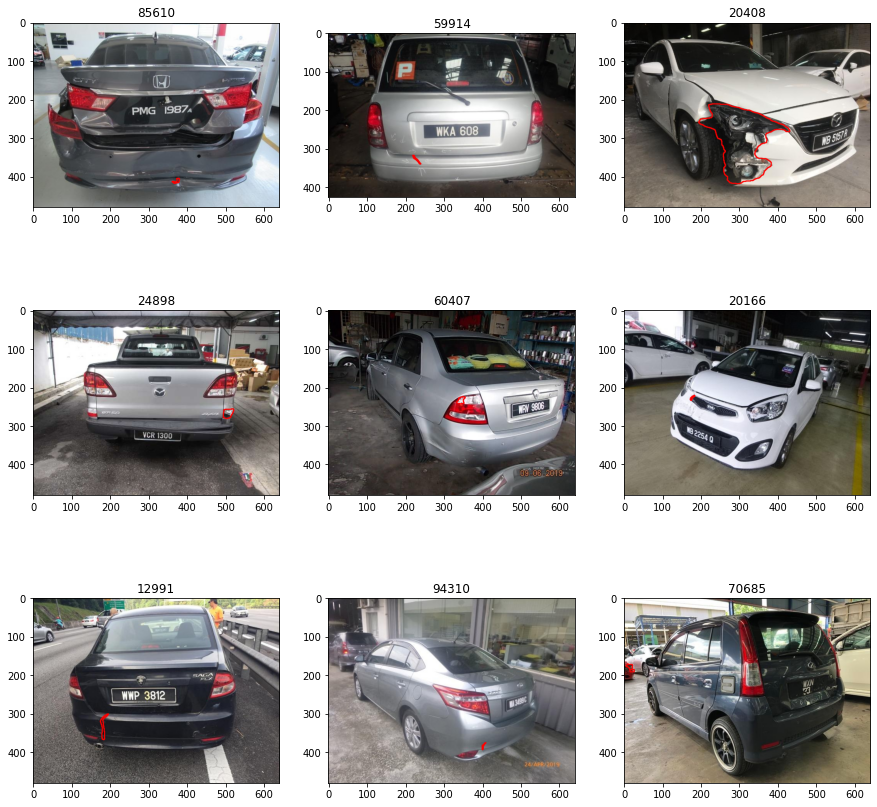

In [76]:
sample(pseudo_data)

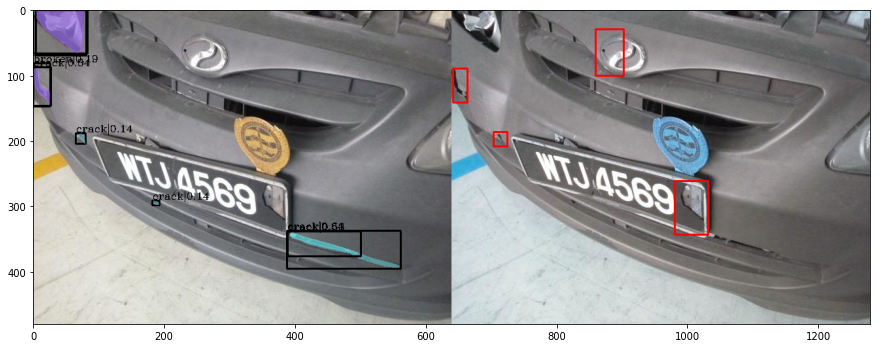

In [28]:
i = [i for i in data['images'] if i['id']==17869][0]
img = cv2.imread(str(path/'images'/i['file_name']))
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id'] == i['id']]
img_annos = cv2.drawContours(img.copy(),annos,-1,(255,0,0),2)

result = inference_detector(model, img)
img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, img.copy(), result,score_thr=0.1)

plt.figure(figsize=(15, 15))
plt.imshow(np.hstack((img_,img_annos)))

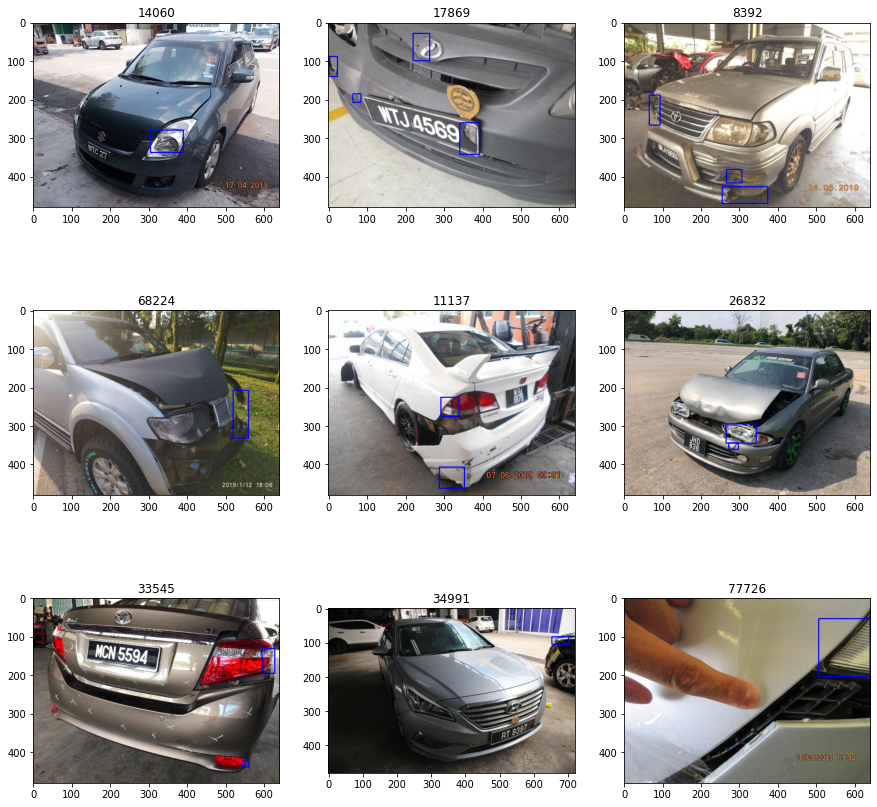

In [16]:
sample(data)

81933 79602


In [65]:
dent : 5559/8458

0.657247576259163

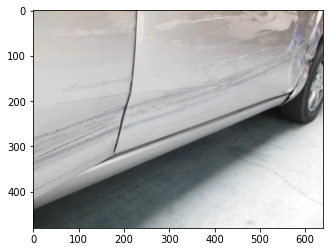

In [8]:
img_data = data['images'][0]
image = cv2.imread(str(path/'images'/img_data['file_name']))
plt.imshow(image)